Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset root: /content/drive/MyDrive/colabdata/dataset
Image folder: /content/drive/MyDrive/colabdata/dataset/Img
Exists?: True True
Using CSV: /content/drive/MyDrive/colabdata/dataset/english.csv
CSV columns: ['image', 'label']
Detected file column: image
Detected label column: label
Resolved images: 3410 Missing entries: 0


Loading images: 100%|██████████| 3410/3410 [01:10<00:00, 48.54it/s]


Loaded X: (3410, 784) y: (3410,)
Num classes: 62
Shapes -> train: (2182, 784) val: (546, 784) test: (682, 784)


Grid search: 100%|██████████| 216/216 [10:54<00:00,  3.03s/it]



Best Params: (32, 0.001, 256, 'sigmoid', 'adam', 1)
Best Val Accuracy: 0.25824175824175827

MLP Test Accuracy: 0.2316715542521994

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.18      0.29        11
           1       0.15      0.45      0.22        11
           2       0.25      0.09      0.13        11
           3       0.33      0.09      0.14        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.17      0.36      0.23        11
           7       0.13      0.18      0.15        11
           8       0.71      0.45      0.56        11
           9       0.18      0.36      0.24        11
           A       0.27      0.55      0.36        11
           B       0.29      0.36      0.32        11
           C       0.39      0.82      0.53        11
           D       0.00      0.00      0.00        11
           E       0.00      0.00

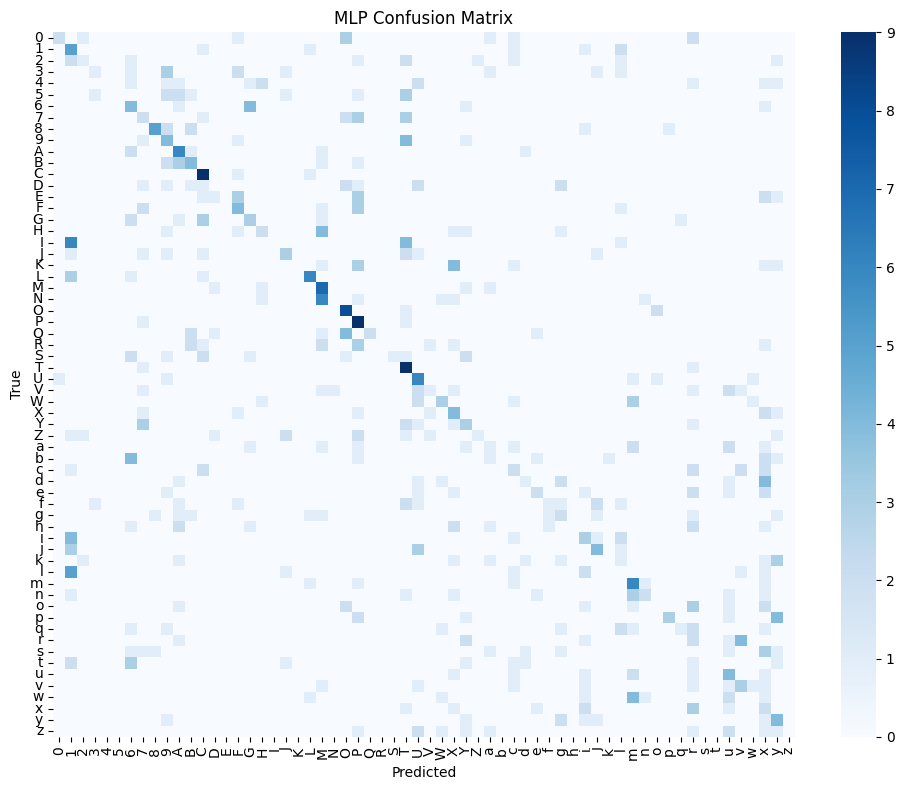

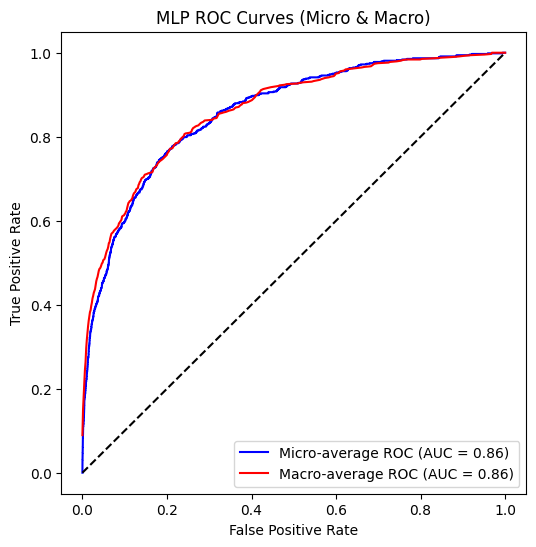

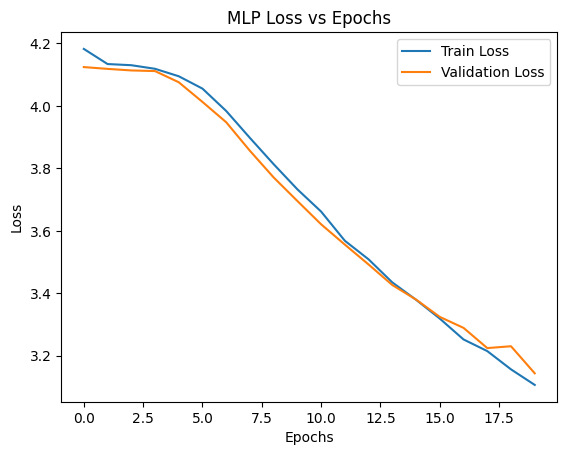

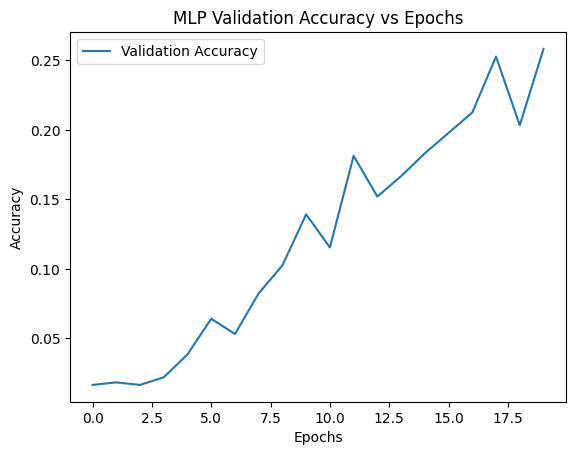

Saved best MLP model to /content/mlp_best_model.pth

Summary:
 - Num classes: 62
 - Train: 2182 Val: 546 Test: 682
 - Best params: (32, 0.001, 256, 'sigmoid', 'adam', 1)
 - Best val acc: 0.25824175824175827
 - Test acc: 0.2316715542521994 Macro F1 (approx): 0.19225845356806445


In [3]:
# === MLP (Multilayer Perceptron) — formatted outputs to match friend's notebook ===
# Paste this single cell into Colab and run.

# 1) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

DATASET_ROOT = '/content/drive/MyDrive/colabdata/dataset'
IMG_FOLDER = DATASET_ROOT + '/Img'
import os, pickle
print("Dataset root:", DATASET_ROOT)
print("Image folder:", IMG_FOLDER)
print("Exists?:", os.path.exists(DATASET_ROOT), os.path.exists(IMG_FOLDER))

# 2) Install / imports
!pip install --quiet tqdm torch torchvision seaborn
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, roc_curve, auc, classification_report)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 3) CSV finder + load (same strategy as before)
def find_csv_file(dataset_root):
    candidates = [f for f in os.listdir(dataset_root) if f.lower().endswith('.csv')]
    if not candidates:
        raise FileNotFoundError(f"No CSV file found in {dataset_root}.")
    return os.path.join(dataset_root, candidates[0])

CSV_PATH = find_csv_file(DATASET_ROOT)
print("Using CSV:", CSV_PATH)
df = pd.read_csv(CSV_PATH).dropna().reset_index(drop=True)
print("CSV columns:", df.columns.tolist())

# 4) detect file & label columns (best-effort)
possible_file_cols = ['filename','file','image','img','path','image_path','file_name']
possible_label_cols = ['label','class','target','y']
file_col = next((c for c in df.columns if any(p in c.lower() for p in possible_file_cols)), df.columns[0])
label_col = next((c for c in df.columns if any(p in c.lower() for p in possible_label_cols)), (df.columns[1] if len(df.columns)>1 else df.columns[0]))
print("Detected file column:", file_col)
print("Detected label column:", label_col)

# 5) build X,y using the same preprocessing as earlier: grayscale 28x28 flatten
def resolve_image_path(fname, img_folder, dataset_root):
    if os.path.isabs(fname) and os.path.exists(fname):
        return fname
    p1 = os.path.join(img_folder, fname); p2 = os.path.join(img_folder, os.path.basename(fname))
    p3 = os.path.join(dataset_root, fname)
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    if os.path.exists(p3): return p3
    # recursive search
    base = os.path.basename(fname).lower()
    if os.path.exists(img_folder):
        for root, _, files in os.walk(img_folder):
            for f in files:
                if f.lower() == base:
                    return os.path.join(root, f)
    for root, _, files in os.walk(dataset_root):
        for f in files:
            if f.lower() == base:
                return os.path.join(root, f)
    return None

def load_and_preprocess(img_path, size=(28,28)):
    img = Image.open(img_path).convert("L").resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32)/255.0
    return arr.flatten()

image_paths, labels = [], []
missing = []
for _, row in df.iterrows():
    fname = str(row[file_col])
    resolved = resolve_image_path(fname, IMG_FOLDER, DATASET_ROOT)
    if resolved:
        image_paths.append(resolved)
        labels.append(row[label_col])
    else:
        missing.append(fname)

print("Resolved images:", len(image_paths), "Missing entries:", len(missing))
if len(image_paths) == 0:
    raise ValueError("No images found. Check CSV and Img folder.")

X_list = []
failed = []
for p in tqdm(image_paths, desc="Loading images"):
    try:
        X_list.append(load_and_preprocess(p, size=(28,28)))
    except Exception as e:
        failed.append((p,str(e)))
if failed:
    print("Warning: some images failed to load. Example:", failed[:3])

X = np.vstack(X_list)
y_raw = np.array(labels)
print("Loaded X:", X.shape, "y:", y_raw.shape)

# 6) Encode labels and splits (match friend's layout: train_full -> train/val)
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Num classes:", len(le.classes_))

RNG_SEED = 42
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG_SEED
)
# split train_full into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=RNG_SEED
)
print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# convert to tensors and dataloaders helper
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

def get_loader(Xt, yt, batch_size, shuffle=True):
    ds = TensorDataset(Xt, yt)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# 7) MLP model class (match friend's architecture)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation="relu", num_hidden=1):
        super().__init__()
        act_fn = {"relu": nn.ReLU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}[activation]
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(act_fn)
        if num_hidden == 2:
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(act_fn)
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# 8) training function (EPOCHS = 20 while searching)
def train_model(params):
    batch_size, lr, hidden_dim, activation, optimizer_name, num_hidden = params
    train_loader = get_loader(X_train_t, y_train_t, batch_size=batch_size, shuffle=True)
    val_loader = get_loader(X_val_t, y_val_t, batch_size=batch_size, shuffle=False)
    model = MLP(X_train.shape[1], hidden_dim, len(le.classes_), activation, num_hidden)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    EPOCHS = 20
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item()
                preds = out.argmax(dim=1)
                correct += (preds == yb).sum().item()
        acc = correct / len(val_loader.dataset)
        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(acc)
        # (optional) print progress smaller to reduce verbosity
        # print(f"Epoch {epoch+1}/{EPOCHS} - tr_loss={train_loss/len(train_loader):.4f} val_loss={val_loss/len(val_loader):.4f} val_acc={acc:.4f}")
    return model, history

# 9) Search space (match friend's)
search_space = [
    (bs, lr, hd, act, opt, nh)
    for bs in [32, 64, 128]
    for lr in [0.1, 0.01, 0.001]
    for hd in [128, 256]
    for act in ["relu", "tanh", "sigmoid"]
    for opt in ["sgd", "adam"]
    for nh in [1, 2]
]

best_acc, best_params, best_model, best_history = 0, None, None, None

# run grid search (this may be long — consider reducing grid during debug)
for params in tqdm(search_space, desc="Grid search"):
    model_cand, hist_cand = train_model(params)
    final_val_acc = hist_cand["val_acc"][-1]
    if final_val_acc > best_acc:
        best_acc = final_val_acc
        best_params = params
        best_model = model_cand
        best_history = hist_cand

print("\nBest Params:", best_params)
print("Best Val Accuracy:", best_acc)

# 10) Evaluate best model on test set (use probabilities)
best_model.eval()
with torch.no_grad():
    out_test = best_model(X_test_t)
    probs = torch.softmax(out_test, dim=1).cpu().numpy()
    preds = probs.argmax(axis=1)

print("\nMLP Test Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n")
print(classification_report(y_test, preds, target_names=le.classes_, zero_division=0))

# 11) Confusion Matrix (seaborn heatmap) similar to friend's visual
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_, cbar=True, annot=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP Confusion Matrix")
plt.tight_layout()
plt.show()

# 12) ROC Curves (Micro & Macro) using predicted probabilities
try:
    # binarize true labels
    y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
    # micro ROC (using probabilities)
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # per-class ROC and macro-average
    fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
    for i in range(len(le.classes_)):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

    # compute macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(le.classes_))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(le.classes_)):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= len(le.classes_)
    roc_auc_macro = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})", color="blue")
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {roc_auc_macro:.2f})", color="red")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("MLP ROC Curves (Micro & Macro)")
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print("ROC calculation failed:", e)

# 13) Loss & Val Accuracy plots for the best history (like friend's)
if best_history is not None:
    plt.figure()
    plt.plot(best_history["train_loss"], label="Train Loss")
    plt.plot(best_history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("MLP Loss vs Epochs")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(best_history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("MLP Validation Accuracy vs Epochs")
    plt.legend()
    plt.show()

# 14) Save best model and encoder (optional)
save_path = "/content/mlp_best_model.pth"
torch.save({"model_state": best_model.state_dict(), "best_params": best_params, "label_encoder": le}, save_path)
print("Saved best MLP model to", save_path)

# 15) Final summary
print("\nSummary:")
print(" - Num classes:", len(le.classes_))
print(" - Train:", X_train.shape[0], "Val:", X_val.shape[0], "Test:", X_test.shape[0])
print(" - Best params:", best_params)
print(" - Best val acc:", best_acc)
print(" - Test acc:", accuracy_score(y_test, preds), "Macro F1 (approx):", np.mean(precision_recall_fscore_support(y_test, preds, average=None, zero_division=0)[2]))
